In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import time
import sys
import pytorch_model_summary
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm


print(f'torch : {torch.__version__}')
print(f'python : {sys.version}')

torch : 1.11.0
python : 3.8.12 (default, Oct 12 2021, 13:49:34) 
[GCC 7.5.0]


In [2]:

class ImageData(Dataset):
    def __init__(self,path,transform=None,target_transform=None):
        self.path = path
        self.files =[]
        self.labels = []
        for i in os.listdir(path):
            if i[:-3]+'png' in os.listdir(path+'/label'):
                self.files.append(i)
                self.labels.append(i[:-3]+'png')
        self.transform = transform
        self.target_transform = target_transform
        self.to_tensor = transforms.ToTensor()
        
    def __getitem__(self,idx):
        img = Image.open(self.path+'/'+self.files[idx])
        label = Image.open(self.path+'/label/'+self.labels[idx])
        #img = np.array(img)[:,:256]
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            label = self.target_transform(label)
        return img, label

    def __len__(self):
        return len(self.files)

class ConvertToBackground(object):
    def __call__(self, img):
        img = np.asarray(img,dtype=np.uint8)
        img[img==255] = 0
        # 64bit 부호 정수 long 타입 Tensor로 변환 
        img = torch.from_numpy(img).long()
        return img


In [3]:
data_mean = [0.485, 0.456, 0.406]
data_std = [0.229, 0.224, 0.225]

transform = transforms.Compose(
    [
        transforms.Resize((224,224)),
        #transforms.RandomHorizontalFlip(),
        #transforms.RandomCrop((224,224)),
        #transforms.RandomAffine(degrees=15),
        # PIL 타입의 [0,255] data를 [0,1]의 FloatTensor로 변환
        transforms.ToTensor(),
        transforms.Normalize(mean=data_mean,std=data_std)
    ]
)
val_transform = transforms.Compose(
    [
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=data_mean,std=data_std)
    ]
)
label_transform = transforms.Compose(
    [
        transforms.Resize((224,224)),
        # 경계를 배경으로 처리
        ConvertToBackground()
    ]
)

batch_size = 4
train_path = './data/train'
train_set = ImageData(train_path,transform,label_transform)
#train_set = torchvision.datasets.VOCSegmentation(root='./data', year='2012',\
#    image_set='train',download=False,transform=transform,target_transform=label_transform)
train_loader = DataLoader(train_set, batch_size= batch_size,shuffle=True)
val_path = './data/val'
val_set = ImageData(val_path,val_transform,label_transform)
#val_set = torchvision.datasets.VOCSegmentation(root='./data', year='2012',\
#    image_set='val',download=False,transform=transform,target_transform=label_transform)
val_loader = DataLoader(val_set, batch_size= batch_size,shuffle=True)


In [4]:
#a,b = train_set[0]
#print(a.shape)

print(len(train_loader))
#temp_img,temp_label = next(iter(train_loader))
#print(temp_img)

366


In [5]:
# 사전에 학습된 vgg16 parameter 가져오기
vgg16 = torchvision.models.vgg16(pretrained=True)
for param in vgg16.features.parameters():
   param.requires_grad = False
print(vgg16.features)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [6]:
class FCN16(nn.Module):
    # vgg 16 
    def __init__(self,num_class):
        super(FCN16, self).__init__()
        self.vgg16 = vgg16.features

        self.fc1 = nn.Conv2d(in_channels=512,out_channels=4096,kernel_size=1)
        self.fc2 = nn.Conv2d(4096,4096,kernel_size=1)
        self.fc3 = nn.Conv2d(4096,num_class,kernel_size=1)
        self.pool4_conv = nn.Conv2d(512,21,kernel_size=1)

        self.upsample2 = nn.ConvTranspose2d(num_class, num_class,2,2)
        self.upsample16 = nn.ConvTranspose2d(num_class,num_class,16,16)
        # self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        # self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        # self.bn2     = nn.BatchNorm2d(256)
        # self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        # self.bn3     = nn.BatchNorm2d(128)
        # self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        # self.bn4     = nn.BatchNorm2d(64)
        # self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        # self.bn5     = nn.BatchNorm2d(32)
        # self.classifier = nn.Conv2d(32, num_class, kernel_size=1)
        # self.relu    = nn.ReLU(inplace=True)
        #self._initialize_weights()
    def forward(self, x):
        pool4 = self.vgg16[:-7](x)
        pool5 = self.vgg16[-7:](pool4)

        #print(pool5.shape)
        pool5 = self.fc1(pool5)
        #print(pool5.shape)
        pool5 = nn.ReLU()(pool5)
        pool5 = nn.Dropout2d(0.5)(pool5)
        pool5 = self.fc2(pool5)
        pool5 = nn.ReLU()(pool5)
        pool5 = nn.Dropout2d(0.5)(pool5)
        pool5 = self.fc3(pool5)

        pool5 = self.upsample2(pool5)
        pool4 = self.pool4_conv(pool4)
        x = pool5 + pool4
        x = self.upsample16(x)
        # print(pool5.shape)
        # print(pool4.shape)
        
        # pool5 = self.deconv1(pool5)
        # #print(pool5.shape)
        # #print(pool4.shape)
        # x = pool5 + pool4
        # x = self.relu(self.deconv2(x))
        # x = self.bn2(x)
        # x = self.relu(self.deconv3(x))
        # x = self.bn3(x)
        # x = self.relu(self.deconv4(x))
        # x = self.bn4(x)
        # x = self.relu(self.deconv5(x))
        # x = self.bn5(x)
        # x = self.classifier(x)
        #print(x.shape)
        #print(x.shape)
        #x = self.upsample16(x)
        #print(x.shape)
        return x
    # def _initialize_weights(self):
    #         for m in self.modules():
    #             if isinstance(m, nn.Conv2d):
    #                 m.weight.data.zero_()
    #                 if m.bias is not None:
    #                     m.bias.data.zero_()
    # def make_block(self, in_channel, out_channel, repeat):
    #     layers = []
    #     for i in range(repeat):
    #         if (i==0):
    #             layers.append(nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1, stride=1))
    #         else:
    #             layers.append(nn.Conv2d(out_channel,out_channel,kernel_size=3, padding=1, stride=1))
    #         layers.append(nn.BatchNorm2d(out_channel))
    #         layers.append(nn.ReLU())
    #     layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    #     block = nn.Sequential(*layers)

    #     return block

In [7]:
FCN =FCN16(num_class=21)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')
#print(FCN)
print(pytorch_model_summary.summary(FCN,torch.zeros(batch_size,3,224,224),show_input=True))

Using cuda device
-----------------------------------------------------------------------------
         Layer (type)            Input Shape         Param #     Tr. Param #
             Conv2d-1       [4, 3, 224, 224]           1,792               0
               ReLU-2      [4, 64, 224, 224]               0               0
             Conv2d-3      [4, 64, 224, 224]          36,928               0
               ReLU-4      [4, 64, 224, 224]               0               0
          MaxPool2d-5      [4, 64, 224, 224]               0               0
             Conv2d-6      [4, 64, 112, 112]          73,856               0
               ReLU-7     [4, 128, 112, 112]               0               0
             Conv2d-8     [4, 128, 112, 112]         147,584               0
               ReLU-9     [4, 128, 112, 112]               0               0
         MaxPool2d-10     [4, 128, 112, 112]               0               0
            Conv2d-11       [4, 128, 56, 56]         295,

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(FCN.parameters(), lr=0.0001)

In [9]:
def pixel_accuracy(output, label):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1),dim=1)
        correct = torch.eq(output, label).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy
# https://sanghyu.tistory.com/3 -- view, contiguous
def mIoU(output, label,num_classes=21):
    with torch.no_grad():
        output = F.softmax(output, dim=1)
        output = torch.argmax(output, dim=1)
        # 메모리에 저장된 순서를 하나씩, view할때 섞이지 않도록
        output = output.contiguous().view(-1)
        label = label.contiguous().view(-1)
    
        iou_class = []
        for c in range(0, num_classes):
            output_true = output==c
            label_true = label==c

            if label_true.long().sum().item() == 0:
                iou_class.append(np.nan)
            else:
                intersect = torch.logical_and(output_true,label_true).sum().float().item()
                union = torch.logical_or(output_true,label_true).sum().float().item()
                iou= intersect/union
                iou_class.append(iou)
        return np.nanmean(iou_class)

def get_lr(optim):
    for param_group in optim.param_groups:
        return param_group['lr']

In [10]:
# 학습
FCN.to(device)
epochs= 50
best_loss = 0
train_loss_list = []
train_acc_list = []
train_iou_list = []
val_loss_list = []
val_acc_list = []
val_iou_list = []
min_miou = 0
lrs = []
for epoch in range(epochs):
    val_running_loss = 0
    train_running_loss =0
    start_time = time.time()
    train_iou_score = 0
    val_iou_score =0
    train_acc = 0
    val_acc = 0

    FCN.train()
    for iter,data in tqdm(enumerate(train_loader)):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = FCN(inputs)
        # print(f'input shape : {inputs.shape}')
        # print(f'output shape : {outputs[0][0].shape}')
        # print(f'output  --{outputs[0][0]}')
        # print(f'labels shape : {labels.shape}')
        # print(f'lable --{labels[labels>0]}')
        loss = criterion(outputs,labels) 
        loss.backward()
        optimizer.step()

        train_iou_score += mIoU(outputs, labels)
        train_acc += pixel_accuracy(outputs, labels)
        train_running_loss += loss.item()
    
    FCN.eval()
    with torch.no_grad():
        for iter, vdata in tqdm(enumerate(val_loader)):
            vinputs, vlabels = vdata
            vinputs = vinputs.to(device)
            vlabels = vlabels.to(device)

            voutputs = FCN(vinputs)
            vloss = criterion(voutputs,vlabels)

            val_running_loss += vloss.item()
            val_iou_score += mIoU(voutputs,vlabels)
            val_acc += pixel_accuracy(voutputs,vlabels)


        train_running_loss /= len(train_loader)
        train_iou_score /=len(train_loader)
        train_acc /=len(train_loader)
        val_running_loss /= len(val_loader)
        val_iou_score /=len(val_loader)
        val_acc /=len(val_loader)
        lrs.append(get_lr(optimizer))

        print(f'{epoch+1} epcoh , time = {time.time()-start_time:.2f}')
        print(f'train loss : {train_running_loss:.5f}, val_loss : {val_running_loss:.5f}')
        print(f'train IoU : {train_iou_score:.5f}, val IoU : {val_iou_score:.5f}')
        print(f'train Acc : {train_acc:.5f}, val Acc : {val_acc:.5f}')
        train_loss_list.append(train_running_loss)
        train_iou_list.append(train_iou_score)
        train_acc_list.append(train_acc)
        val_loss_list.append(val_running_loss)
        val_iou_list.append(val_iou_score)
        val_acc_list.append(val_acc)

        if min_miou < val_iou_score:
            min_miou = val_iou_score
            #print('save model')
            torch.save(FCN, './models/FCN16-Vgg16.pt') 
            
                   
history = {'train_loss': train_loss_list, 'val_loss':val_loss_list,'train_miou': train_iou_list,
'val_miou':val_iou_list,'train_acc':train_acc_list,'val_acc':val_acc_list, 'lr':lrs}
print('Finish Training')

366it [00:29, 12.33it/s]
363it [00:23, 15.62it/s]


1 epcoh , time = 52.93
train loss : 1.44258, val_loss : 1.08940
train IoU : 0.12245, val IoU : 0.13000
train Acc : 0.68838, val Acc : 0.74759


366it [00:27, 13.42it/s]
363it [00:23, 15.50it/s]


2 epcoh , time = 50.70
train loss : 1.04392, val_loss : 1.00061
train IoU : 0.14121, val IoU : 0.15460
train Acc : 0.75091, val Acc : 0.75371


366it [00:27, 13.26it/s]
363it [00:23, 15.33it/s]


3 epcoh , time = 51.29
train loss : 0.90819, val_loss : 0.84530
train IoU : 0.19910, val IoU : 0.21924
train Acc : 0.77181, val Acc : 0.77872


366it [00:26, 14.05it/s]
363it [00:23, 15.65it/s]


4 epcoh , time = 49.26
train loss : 0.80207, val_loss : 0.78462
train IoU : 0.23820, val IoU : 0.24549
train Acc : 0.78764, val Acc : 0.78998


366it [00:29, 12.58it/s]
363it [00:23, 15.47it/s]


5 epcoh , time = 52.58
train loss : 0.74620, val_loss : 0.75277
train IoU : 0.26076, val IoU : 0.26560
train Acc : 0.79758, val Acc : 0.79330


366it [00:28, 12.83it/s]
363it [00:23, 15.39it/s]


6 epcoh , time = 52.11
train loss : 0.69853, val_loss : 0.71214
train IoU : 0.28794, val IoU : 0.29417
train Acc : 0.80700, val Acc : 0.80392


366it [00:28, 13.01it/s]
363it [00:24, 15.06it/s]


7 epcoh , time = 52.23
train loss : 0.66324, val_loss : 0.70816
train IoU : 0.30718, val IoU : 0.30141
train Acc : 0.81328, val Acc : 0.80111


366it [00:28, 12.82it/s]
363it [00:24, 15.05it/s]


8 epcoh , time = 52.67
train loss : 0.63277, val_loss : 0.67853
train IoU : 0.32933, val IoU : 0.32836
train Acc : 0.82023, val Acc : 0.81093


366it [00:28, 13.00it/s]
363it [00:23, 15.14it/s]


9 epcoh , time = 52.14
train loss : 0.60930, val_loss : 0.66797
train IoU : 0.34173, val IoU : 0.32048
train Acc : 0.82473, val Acc : 0.81272


366it [00:27, 13.19it/s]
363it [00:23, 15.15it/s]


10 epcoh , time = 51.72
train loss : 0.58427, val_loss : 0.65709
train IoU : 0.34957, val IoU : 0.33794
train Acc : 0.82993, val Acc : 0.81629


366it [00:29, 12.58it/s]
363it [00:24, 14.88it/s]


11 epcoh , time = 53.48
train loss : 0.55901, val_loss : 0.65013
train IoU : 0.36761, val IoU : 0.34194
train Acc : 0.83570, val Acc : 0.81585


366it [00:28, 12.90it/s]
363it [00:25, 14.06it/s]


12 epcoh , time = 54.20
train loss : 0.53620, val_loss : 0.63389
train IoU : 0.39053, val IoU : 0.35431
train Acc : 0.83961, val Acc : 0.82258


366it [00:27, 13.28it/s]
363it [00:24, 14.89it/s]


13 epcoh , time = 51.95
train loss : 0.50737, val_loss : 0.62845
train IoU : 0.40949, val IoU : 0.37550
train Acc : 0.84861, val Acc : 0.82193


366it [00:27, 13.30it/s]
363it [00:24, 15.10it/s]


14 epcoh , time = 51.57
train loss : 0.48502, val_loss : 0.61078
train IoU : 0.43081, val IoU : 0.37346
train Acc : 0.85400, val Acc : 0.82965


366it [00:27, 13.51it/s]
363it [00:24, 14.70it/s]


15 epcoh , time = 51.79
train loss : 0.46184, val_loss : 0.60579
train IoU : 0.44664, val IoU : 0.40667
train Acc : 0.86040, val Acc : 0.82843


366it [00:26, 13.56it/s]
363it [00:23, 15.32it/s]


16 epcoh , time = 50.69
train loss : 0.44088, val_loss : 0.59640
train IoU : 0.46088, val IoU : 0.40932
train Acc : 0.86568, val Acc : 0.83391


366it [00:26, 13.56it/s]
363it [00:24, 14.93it/s]


17 epcoh , time = 51.31
train loss : 0.42272, val_loss : 0.61653
train IoU : 0.47701, val IoU : 0.39269
train Acc : 0.87053, val Acc : 0.83408


366it [00:28, 13.02it/s]
363it [00:24, 14.99it/s]


18 epcoh , time = 52.33
train loss : 0.40692, val_loss : 0.59808
train IoU : 0.49014, val IoU : 0.41647
train Acc : 0.87492, val Acc : 0.83451


366it [00:28, 12.94it/s]
363it [00:24, 14.76it/s]


19 epcoh , time = 52.90
train loss : 0.38800, val_loss : 0.60271
train IoU : 0.50017, val IoU : 0.42026
train Acc : 0.88049, val Acc : 0.83712


366it [00:27, 13.08it/s]
363it [00:24, 14.79it/s]


20 epcoh , time = 52.52
train loss : 0.37543, val_loss : 0.60816
train IoU : 0.51130, val IoU : 0.41979
train Acc : 0.88310, val Acc : 0.83566


366it [00:26, 13.71it/s]
363it [00:22, 15.82it/s]


21 epcoh , time = 49.65
train loss : 0.36024, val_loss : 0.61095
train IoU : 0.51941, val IoU : 0.41931
train Acc : 0.88759, val Acc : 0.83618


366it [00:28, 13.04it/s]
363it [00:23, 15.50it/s]


22 epcoh , time = 51.49
train loss : 0.35325, val_loss : 0.61993
train IoU : 0.52892, val IoU : 0.41761
train Acc : 0.88968, val Acc : 0.83731


366it [00:27, 13.21it/s]
363it [00:23, 15.36it/s]


23 epcoh , time = 51.33
train loss : 0.33550, val_loss : 0.62128
train IoU : 0.53887, val IoU : 0.42858
train Acc : 0.89450, val Acc : 0.83934


366it [00:27, 13.16it/s]
363it [00:23, 15.26it/s]


24 epcoh , time = 51.61
train loss : 0.32545, val_loss : 0.62350
train IoU : 0.54531, val IoU : 0.42658
train Acc : 0.89746, val Acc : 0.83546


366it [00:26, 13.63it/s]
363it [00:23, 15.14it/s]


25 epcoh , time = 50.83
train loss : 0.31142, val_loss : 0.63281
train IoU : 0.55602, val IoU : 0.43570
train Acc : 0.90066, val Acc : 0.83642


366it [00:28, 12.87it/s]
363it [00:23, 15.35it/s]


26 epcoh , time = 52.09
train loss : 0.30320, val_loss : 0.65498
train IoU : 0.56716, val IoU : 0.41979
train Acc : 0.90350, val Acc : 0.83745


366it [00:28, 12.78it/s]
363it [00:22, 15.82it/s]


27 epcoh , time = 51.59
train loss : 0.29122, val_loss : 0.63506
train IoU : 0.57484, val IoU : 0.43769
train Acc : 0.90689, val Acc : 0.83667


366it [00:27, 13.34it/s]
363it [00:24, 15.11it/s]


28 epcoh , time = 51.46
train loss : 0.27987, val_loss : 0.67450
train IoU : 0.58453, val IoU : 0.42498
train Acc : 0.90983, val Acc : 0.83740


366it [00:28, 13.07it/s]
363it [00:23, 15.58it/s]


29 epcoh , time = 51.30
train loss : 0.27263, val_loss : 0.66432
train IoU : 0.58945, val IoU : 0.43374
train Acc : 0.91252, val Acc : 0.83758


366it [00:27, 13.12it/s]
363it [00:22, 16.00it/s]


30 epcoh , time = 50.60
train loss : 0.26438, val_loss : 0.66476
train IoU : 0.59841, val IoU : 0.43513
train Acc : 0.91488, val Acc : 0.83592


366it [00:27, 13.14it/s]
363it [00:23, 15.61it/s]


31 epcoh , time = 51.12
train loss : 0.25556, val_loss : 0.70602
train IoU : 0.60334, val IoU : 0.42541
train Acc : 0.91740, val Acc : 0.83641


366it [00:27, 13.37it/s]
363it [00:23, 15.35it/s]


32 epcoh , time = 51.02
train loss : 0.24876, val_loss : 0.68536
train IoU : 0.61295, val IoU : 0.43401
train Acc : 0.91965, val Acc : 0.83746


366it [00:27, 13.36it/s]
363it [00:23, 15.52it/s]


33 epcoh , time = 50.78
train loss : 0.24040, val_loss : 0.68719
train IoU : 0.61376, val IoU : 0.43876
train Acc : 0.92194, val Acc : 0.83422


366it [00:26, 13.60it/s]
363it [00:23, 15.26it/s]


34 epcoh , time = 50.69
train loss : 0.23644, val_loss : 0.68931
train IoU : 0.62408, val IoU : 0.43549
train Acc : 0.92356, val Acc : 0.83712


366it [00:26, 13.70it/s]
363it [00:24, 14.71it/s]


35 epcoh , time = 51.39
train loss : 0.23250, val_loss : 0.72477
train IoU : 0.62943, val IoU : 0.42996
train Acc : 0.92438, val Acc : 0.83956


366it [00:26, 13.56it/s]
363it [00:23, 15.17it/s]


36 epcoh , time = 50.93
train loss : 0.22395, val_loss : 0.74273
train IoU : 0.63613, val IoU : 0.42268
train Acc : 0.92726, val Acc : 0.83871


366it [00:27, 13.22it/s]
363it [00:24, 14.81it/s]


37 epcoh , time = 52.19
train loss : 0.21897, val_loss : 0.73039
train IoU : 0.63401, val IoU : 0.43953
train Acc : 0.92807, val Acc : 0.83775


366it [00:27, 13.39it/s]
363it [00:24, 15.04it/s]


38 epcoh , time = 51.49
train loss : 0.21299, val_loss : 0.73787
train IoU : 0.63964, val IoU : 0.43420
train Acc : 0.93030, val Acc : 0.83499


366it [00:27, 13.14it/s]
363it [00:24, 14.87it/s]


39 epcoh , time = 52.25
train loss : 0.20833, val_loss : 0.74309
train IoU : 0.64474, val IoU : 0.44308
train Acc : 0.93185, val Acc : 0.83575


366it [00:26, 13.59it/s]
363it [00:24, 14.90it/s]


40 epcoh , time = 51.31
train loss : 0.20250, val_loss : 0.75515
train IoU : 0.64742, val IoU : 0.44156
train Acc : 0.93298, val Acc : 0.83511


366it [00:27, 13.41it/s]
363it [00:25, 14.40it/s]


41 epcoh , time = 52.51
train loss : 0.19984, val_loss : 0.76784
train IoU : 0.65446, val IoU : 0.43873
train Acc : 0.93342, val Acc : 0.83807


366it [00:26, 13.90it/s]
363it [00:24, 14.61it/s]


42 epcoh , time = 51.17
train loss : 0.19711, val_loss : 0.75878
train IoU : 0.65523, val IoU : 0.43546
train Acc : 0.93526, val Acc : 0.84009


366it [00:26, 13.65it/s]
363it [00:25, 14.20it/s]


43 epcoh , time = 52.38
train loss : 0.18994, val_loss : 0.76194
train IoU : 0.66381, val IoU : 0.43821
train Acc : 0.93685, val Acc : 0.83493


366it [00:27, 13.39it/s]
363it [00:24, 14.92it/s]


44 epcoh , time = 51.67
train loss : 0.18679, val_loss : 0.78620
train IoU : 0.66584, val IoU : 0.43807
train Acc : 0.93731, val Acc : 0.83903


366it [00:27, 13.40it/s]
363it [00:24, 14.82it/s]


45 epcoh , time = 51.81
train loss : 0.18604, val_loss : 0.81378
train IoU : 0.66299, val IoU : 0.43084
train Acc : 0.93766, val Acc : 0.83804


366it [00:26, 13.92it/s]
363it [00:24, 14.64it/s]


46 epcoh , time = 51.10
train loss : 0.18154, val_loss : 0.82628
train IoU : 0.67179, val IoU : 0.42573
train Acc : 0.93876, val Acc : 0.83768


366it [00:26, 13.72it/s]
363it [00:26, 13.82it/s]


47 epcoh , time = 52.95
train loss : 0.17955, val_loss : 0.78322
train IoU : 0.66952, val IoU : 0.43749
train Acc : 0.93926, val Acc : 0.83788


366it [00:26, 13.68it/s]
363it [00:24, 14.52it/s]


48 epcoh , time = 51.76
train loss : 0.17659, val_loss : 0.80387
train IoU : 0.67541, val IoU : 0.43864
train Acc : 0.93995, val Acc : 0.83948


366it [00:26, 13.69it/s]
363it [00:25, 14.29it/s]


49 epcoh , time = 52.14
train loss : 0.17368, val_loss : 0.78626
train IoU : 0.67844, val IoU : 0.44975
train Acc : 0.94076, val Acc : 0.83962


366it [00:26, 13.68it/s]
363it [00:25, 14.16it/s]

50 epcoh , time = 52.39
train loss : 0.17101, val_loss : 0.84192
train IoU : 0.68051, val IoU : 0.43297
train Acc : 0.94171, val Acc : 0.84035
Finish Training


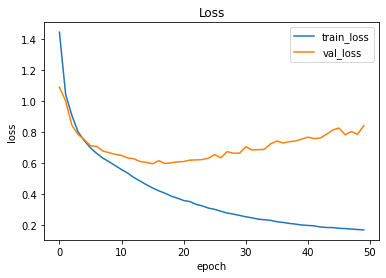

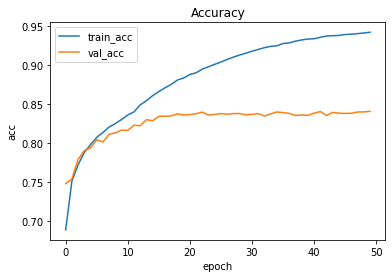

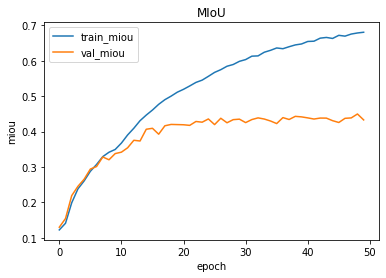

In [11]:
history = {'train_loss': train_loss_list, 'val_loss':val_loss_list,'train_miou': train_iou_list,
'val_miou':val_iou_list,'train_acc':train_acc_list,'val_acc':val_acc_list,'lr':lrs}
def plot_loss(history):
    plt.plot(history['train_loss'], label='train_loss')
    plt.plot(history['val_loss'], label='val_loss')
    plt.title('Loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

def plot_miou(history):
    plt.plot(history['train_miou'], label='train_miou')
    plt.plot(history['val_miou'], label='val_miou')
    plt.title('MIoU')
    plt.xlabel('epoch')
    plt.ylabel('miou')
    plt.legend()
    plt.show()

def plot_acc(history):
    plt.plot(history['train_acc'], label='train_acc')
    plt.plot(history['val_acc'], label='val_acc')
    plt.title('Accuracy')
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.legend()
    plt.show()
plot_loss(history)
plot_acc(history)
plot_miou(history)

In [12]:
best=torch.load('./models/FCN16-Vgg16_up.pt')

In [13]:
def decode_segmap(image, num_class=21):
    label_color = np.array([(0, 0, 0),
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)

    for l in range(0, num_class):
        idx = image==l
        r[idx] = label_color[l,0]
        g[idx] = label_color[l,1]
        b[idx] = label_color[l,2]
    rgb =np.stack([r,g,b], axis=2)
    return rgb

pred shape : torch.Size([21, 224, 224])
pred shape : (224, 224)


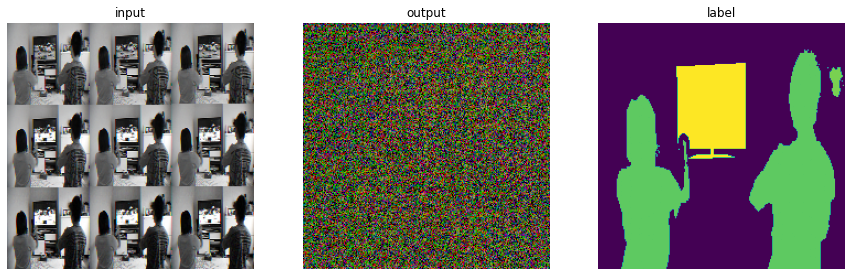

In [14]:
#img, label= train_set[0]
best.eval()
with torch.no_grad():
    for i, data in enumerate(train_loader):
        img, label = data
        
        best.to(device)
        #print(f'input shape:',img.shape)
        img = img.to(device)
        output = best(img)

        # tensor의 추적 제거 detach
        print(f'pred shape : {output[0].shape}')
        pred = torch.argmax(output[0], dim=0).detach().cpu().numpy()
        print(f'pred shape : {pred.shape}')
        pred = decode_segmap(pred,21)
        
        img = img.squeeze() * torch.tensor(data_std).view(3, 1, 1).to(device)
        img = img + torch.tensor(data_mean).view(3, 1, 1).to(device)
        img = img[0].detach().cpu().numpy()
        img = img.reshape(img.shape[1], img.shape[2], img.shape[0])

        plt.figure(figsize=(15,10))
        plt.subplot(1,3,1)
        plt.title('input')
        plt.axis('off')
        plt.imshow(img)
        plt.subplot(1,3,2)
        plt.title('output')
        plt.axis('off')
        plt.imshow(pred)
        plt.subplot(1,3,3)
        plt.title('label')
        plt.axis('off')
        plt.imshow(label[0])
        break
